# 붓꽃의 품종 분류

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("텐서플로 버전: {}".format(tf.__version__))
print("즉시 실행: {}".format(tf.executing_eagerly()))
np.set_printoptions(precision=3, linewidth=500)

텐서플로 버전: 2.0.0-rc1
즉시 실행: True


## 측정된 꽃받침과 꽃잎의 길이와 폭을 토대로 붓꽃을 분류하는 모델을 통해 경사하강법(GD) 학습
* Iris setosa
* Iris virginica
* Iris versicolor

![꽃](https://www.tensorflow.org/images/iris_three_species.jpg)

## 데이터 (CSV)

In [2]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
test__dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url), origin=train_dataset_url)
test__dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(test__dataset_url), origin=test__dataset_url)

print("데이터셋이 복사된 위치: {}".format(train_dataset_fp))
!head -n5 {train_dataset_fp}
!head -n5 {test__dataset_fp}

데이터셋이 복사된 위치: /home/woong/.keras/datasets/iris_training.csv
120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0
30,4,setosa,versicolor,virginica
5.9,3.0,4.2,1.5,1
6.9,3.1,5.4,2.1,2
5.1,3.3,1.7,0.5,0
6.0,3.4,4.5,1.6,1


In [3]:
# column_name = ['꽃잎 길이', '꽃잎 너비', '꽃받침 길이', '꽃받침 너비', '종']
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

# species = 0: Iris setosa, 1: Iris versicolor, 2: Iris virginica
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("특성: {}".format(feature_names))
print("레이블: {}".format(label_name))

특성: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
레이블: species


In [4]:
batch_size = 32
train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    shuffle=False,
    num_epochs=1)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


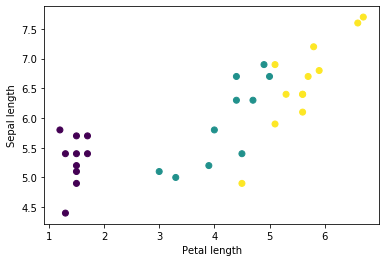

In [5]:
features, labels = next(iter(train_dataset))
plt.scatter(features['petal_length'], features['sepal_length'], c=labels, cmap='viridis')
plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [6]:
def pack_features_vector(features, labels):
  """특성들을 단일 배열로 묶습니다."""
# tf.stack: Stacks a list of rank-R tensors into one rank-(R+1) tensor.
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [7]:
train_dataset = train_dataset.map(pack_features_vector)

In [8]:
train_dataset

<MapDataset shapes: ((None, 4), (None,)), types: (tf.float32, tf.int32)>

In [9]:
features, labels = next(iter(train_dataset))
print(features[:5], labels[:5])

tf.Tensor(
[[6.4 2.8 5.6 2.2]
 [5.  2.3 3.3 1. ]
 [4.9 2.5 4.5 1.7]
 [4.9 3.1 1.5 0.1]
 [5.7 3.8 1.7 0.3]], shape=(5, 4), dtype=float32) tf.Tensor([2 1 2 0 0], shape=(5,), dtype=int32)


## 데이터 (pandas)

In [10]:
# pandas.read_csv : Read a comma-separated values (csv) file into DataFrame.
pdFeature = pd.read_csv(train_dataset_fp, sep=',', skiprows=1, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])

# pandas.DataFrame.pop : Return item and drop from frame. Raise KeyError if not found.
pdLabel = pdFeature.pop('species')

# pandas.DataFrame.head : Return the first n rows.
pdFeature.head(5)

,sepal_length,sepal_width,petal_length,petal_width
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [11]:
# tf.data.Dataset.from_tensor_slices: Creates a Dataset whose elements are slices of the given tensors..
pdDataset = tf.data.Dataset.from_tensor_slices((pdFeature.values, pdLabel.values))
pdFeature.values.shape

(120, 4)

In [12]:
for row, data in enumerate(pdDataset.take(5)):
    print ('Row: {}, Features: {}, Species: {}'.format(row, data[0], data[1]))

Row: 0, Features: [6.4 2.8 5.6 2.2], Species: 2
Row: 1, Features: [5.  2.3 3.3 1. ], Species: 1
Row: 2, Features: [4.9 2.5 4.5 1.7], Species: 2
Row: 3, Features: [4.9 3.1 1.5 0.1], Species: 0
Row: 4, Features: [5.7 3.8 1.7 0.3], Species: 0


## 모델

![](https://www.tensorflow.org/images/custom_estimators/full_network.png)

In [13]:
# tf.keras.Sequential: Linear stack of layers.
# Please check the configuration of each layer (press 'Shift+Tab' in xx.Dense(here!))
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # Weight:  4-inputs * 10-dense =  40,  Bias: 10, Total:  50
  tf.keras.layers.Dense(10, activation=tf.nn.relu),                    # Weight: 10-inputs * 10-dense = 100,  Bias: 10, Total: 110
  tf.keras.layers.Dense(3)                                             # Weight: 10-inputs *  3-dense =  30,  Bias:  3, Total:  33
])
model.summary()
#help(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


## 훈련 (Training) 전 모델 사용

In [14]:
print('Input Shape: {}'.format(features.shape))
for i in range(len(model.layers)):
    print('Layer {}: Weight{} Bias{} Activation{}'.format(i, model.layers[i].weights[0].shape, model.layers[i].bias.shape, model.layers[i].output.shape))

Input Shape: (32, 4)
Layer 0: Weight(4, 10) Bias(10,) Activation(None, 10)
Layer 1: Weight(10, 10) Bias(10,) Activation(None, 10)
Layer 2: Weight(10, 3) Bias(3,) Activation(None, 3)


In [15]:
print('>> 1st Features:\n %s\n'%(features[0].numpy()))
print('>> Weights (Input-Layer1):\n %s\n'%(model.layers[0].weights[0].numpy()))
print('>> Biases   (Input-Layer1):\n %s\n'%(model.layers[0].bias.numpy()))
print('>> Layer1 MatMul[0,0]: %s\n'%(np.sum(features[0]*model.layers[0].weights[0][:,0])))
print('>> Layer1 MatMul: \n %s\n'%(tf.matmul(features, model.layers[0].weights[0]).numpy()[:5]))

actLayer0 = tf.nn.relu(tf.matmul(features,  model.layers[0].weights[0]) + tf.ones([batch_size, 1]) * model.layers[0].bias)
actLayer1 = tf.nn.relu(tf.matmul(actLayer0, model.layers[1].weights[0]) + tf.ones([batch_size, 1]) * model.layers[1].bias)
actLayer2 =            tf.matmul(actLayer1, model.layers[2].weights[0]) + tf.ones([batch_size, 1]) * model.layers[2].bias

>> 1st Features:
 [6.4 2.8 5.6 2.2]

>> Weights (Input-Layer1):
 [[-0.167 -0.257 -0.068 -0.527 -0.582 -0.623 -0.203 -0.606 -0.289 -0.349]
 [-0.337 -0.003 -0.54  -0.258  0.235 -0.642 -0.234 -0.634  0.057 -0.245]
 [-0.301 -0.376  0.417  0.151 -0.446 -0.126  0.287  0.495  0.077  0.385]
 [ 0.595 -0.653 -0.183 -0.379  0.155  0.447  0.41  -0.546 -0.479 -0.411]]

>> Biases   (Input-Layer1):
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

>> Layer1 MatMul[0,0]: -2.3855338

>> Layer1 MatMul: 
 [[-2.386 -5.193 -0.014 -4.08  -5.225 -5.505  0.557 -4.084 -2.312 -1.669]
 [-2.006 -3.184 -0.389 -3.107 -3.688 -4.559 -0.195 -3.402 -1.539 -1.45 ]
 [-2.001 -4.067 -0.117 -3.19  -4.009 -4.463  0.41  -3.256 -1.741 -1.29 ]
 [-2.252 -1.897 -1.4   -3.192 -2.779 -5.185 -1.247 -4.248 -1.172 -1.934]
 [-2.562 -2.311 -1.786 -3.84  -3.138 -6.069 -1.434 -5.188 -1.443 -2.39 ]]



In [16]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=288, shape=(5, 3), dtype=float32, numpy=
array([[ 0.298, -0.165,  0.08 ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.22 , -0.122,  0.059],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ]], dtype=float32)>

In [17]:
actLayer2[:5]

<tf.Tensor: id=292, shape=(5, 3), dtype=float32, numpy=
array([[ 0.298, -0.165,  0.08 ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.22 , -0.122,  0.059],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ]], dtype=float32)>

In [18]:
model.layers[1](model.layers[0](features))[:5]

<tf.Tensor: id=306, shape=(5, 10), dtype=float32, numpy=
array([[0.044, 0.   , 0.   , 0.251, 0.204, 0.   , 0.   , 0.042, 0.139, 0.227],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.032, 0.   , 0.   , 0.185, 0.15 , 0.   , 0.   , 0.031, 0.103, 0.167],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32)>

In [19]:
actLayer1[:5]

<tf.Tensor: id=310, shape=(5, 10), dtype=float32, numpy=
array([[0.044, 0.   , 0.   , 0.251, 0.204, 0.   , 0.   , 0.042, 0.139, 0.227],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.032, 0.   , 0.   , 0.185, 0.15 , 0.   , 0.   , 0.031, 0.103, 0.167],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32)>

## Softmax 적용 (로짓(logit)을 각 클래스에 대한 확률로 변환)
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/bdc1f8eaa8064d15893f1ba6426f20ff8e7149c5)

In [20]:
# Using Numpy
for idx, logitRow in enumerate(predictions[:5]):
    print('Index: {}, Prob. per Class: {}'.format(idx, np.exp(logitRow)/np.sum(np.exp(logitRow))))

Index: 0, Prob. per Class: [0.411 0.259 0.33 ]
Index: 1, Prob. per Class: [0.333 0.333 0.333]
Index: 2, Prob. per Class: [0.39  0.277 0.332]
Index: 3, Prob. per Class: [0.333 0.333 0.333]
Index: 4, Prob. per Class: [0.333 0.333 0.333]


In [21]:
# Using TensorFlow
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=339, shape=(5, 3), dtype=float32, numpy=
array([[0.411, 0.259, 0.33 ],
       [0.333, 0.333, 0.333],
       [0.39 , 0.277, 0.332],
       [0.333, 0.333, 0.333],
       [0.333, 0.333, 0.333]], dtype=float32)>

In [22]:
print("  예측: {}".format(tf.argmax(predictions, axis=1)))
print("레이블: {}".format(labels))

  예측: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
레이블: [2 1 2 0 0 0 0 2 1 0 1 1 0 0 2 1 2 2 2 0 2 2 0 2 2 0 1 2 1 1 1 1]


## 모델 훈련하기

### 손실함수 (Loss Function)

#### 평균 제곱 오차 (Mean Squared Error, MSE) : Regression (회귀) 문제에 주로 사용
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e258221518869aa1c6561bb75b99476c4734108e)

#### 교차 엔트로피 오차 (Cross Entropy Error, CEE) : Classification (분류) 문제에 주로 사용

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/c6b895514e10a3ce88773852cba1cb1e248ed763)

In [23]:
# Cross Entropy Error Using Numpy
cee = 0
for idx, prob in enumerate(tf.nn.softmax(model(features))):
    y  = labels[idx]
    y_ = prob[y]
    cee = cee - np.log(y_)/batch_size
print(cee)

1.1027418933808804


In [24]:
# tf.keras.losses.SparseCategoricalCrossentropy: Computes the crossentropy loss between the labels and predictions.
lossCEE = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
print(lossCEE(y_true=labels, y_pred=model(features)).numpy())
def loss(model, x, y):
  y_ = model(x)
  return lossCEE(y_true=y, y_pred=y_)

1.102742


## 옵티마이저 생성

![](https://cs231n.github.io/assets/nn3/opt1.gif)

In [58]:
# tf.GradientTape: Record operations for automatic differentiation.
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

# tf.keras.optimizers: Built-in optimizer classes.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
var = optimizer.weights

In [80]:
loss_value, grads = grad(model, features, labels)

print("단계: {}, 초기 손실: {}".format(optimizer.iterations.numpy(), loss_value.numpy()))
weights_pre  = optimizer.weights[1].numpy()

optimizer.apply_gradients(zip(grads, model.trainable_variables))
print("단계: {},      손실: {}".format(optimizer.iterations.numpy(), loss(model, features, labels).numpy()))
weights_post = optimizer.weights[1].numpy()

단계: 5, 초기 손실: 0.9541771411895752
단계: 6,      손실: 0.938339352607727


In [81]:
weights_pre

array([[ 0.   ,  0.   ,  0.052,  0.   ,  0.   ,  0.   , -0.005,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.023,  0.   ,  0.   ,  0.   , -0.001,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.003,  0.   ,  0.   ,  0.   , -0.023,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.007,  0.   ,  0.   ,  0.   , -0.014,  0.   ,  0.   ,  0.   ]], dtype=float32)

In [82]:
weights_post

array([[ 0.   ,  0.   ,  0.052,  0.   ,  0.   ,  0.   ,  0.005,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.023,  0.   ,  0.   ,  0.   ,  0.004,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.004,  0.   ,  0.   ,  0.   , -0.021,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.011,  0.   ,  0.   ,  0.   , -0.014,  0.   ,  0.   ,  0.   ]], dtype=float32)

In [83]:
grads[0]

<tf.Tensor: id=3045, shape=(4, 10), dtype=float32, numpy=
array([[ 0.   ,  0.   ,  0.047,  0.   ,  0.   ,  0.   ,  0.098,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.022,  0.   ,  0.   ,  0.   ,  0.049,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.063,  0.   ,  0.   ,  0.   ,  0.002,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.045,  0.   ,  0.   ,  0.   , -0.02 ,  0.   ,  0.   ,  0.   ]], dtype=float32)>

$$m_0 := 0 \text{(Initialize initial 1st moment vector)}$$
$$v_0 := 0 \text{(Initialize initial 2nd moment vector)}$$
$$t := 0 \text{(Initialize timestep)}$$
 |      
 |        The update rule for `variable` with gradient `g` uses an optimization
 |        described at the end of section 2 of the paper:
 |      
 |        $$t := t + 1$$
 |        $$lr_t := \text{learning\_rate} * \sqrt{1 - beta_2^t} / (1 - beta_1^t)$$
 |      
 |        $$m_t := beta_1 * m_{t-1} + (1 - beta_1) * g$$
 |        $$v_t := beta_2 * v_{t-1} + (1 - beta_2) * g * g$$
 |        $$variable := variable - lr_t * m_t / (\sqrt{v_t} + \epsilon)$$

In [91]:
help(optimizer)

Help on Adam in module tensorflow.python.keras.optimizer_v2.adam object:

class Adam(tensorflow.python.keras.optimizer_v2.optimizer_v2.OptimizerV2)
 |  Optimizer that implements the Adam algorithm.
 |  
 |  Adam optimization is a stochastic gradient descent method that is based on
 |  adaptive estimation of first-order and second-order moments.
 |  According to the paper
 |  [Adam: A Method for Stochastic Optimization. Kingma et al.,
 |  2014](http://arxiv.org/abs/1412.6980),
 |   the method is "*computationally efficient, has little memory
 |  requirement, invariant to diagonal rescaling of gradients, and is well suited
 |  for problems that are large in terms of data/parameters*".
 |  
 |  For AMSGrad see [On The Convergence Of Adam And Beyond.
 |  Reddi et al., 5-8](https://openreview.net/pdf?id=ryQu7f-RZ).
 |  
 |  Method resolution order:
 |      Adam
 |      tensorflow.python.keras.optimizer_v2.optimizer_v2.OptimizerV2
 |      tensorflow.python.training.tracking.base.Trackable
 |